In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
from utils.my_utils import load_data
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

In [6]:
X, session_df, requests_df = load_data(csv_path='../dataset/output.log', req_thres=4, normalize_feat=True)

LOADING THE DATASET...


Skipping line 601729: Expected 7 fields in line 601729, saw 23. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


DATASET HAS BEEN LOADED SUCESSFULLY!


In [9]:
X['is_bot'] = X['is_bot'].astype(int)
X['is_pc'] = X['is_pc'].astype(int)

to_model_cols = X.columns[:15]
X_train = X[to_model_cols].copy()

print('X_train shape: {}'.format(X_train.shape))

X_train shape: (33451, 15)


In [10]:
X_train.columns

Index(['requests_count', 'path_length_std', '4xx_percentage(%)',
       '3xx_percentage(%)', 'HEAD_count(%)', 'image_count(%)',
       'total_response_length', 'mean_response_length', 'total_response_time',
       'mean_response_time', 'avg_path_count_norm', 'robots_txt_reqs',
       'is_bot', 'is_pc', 'avg_time_diff'],
      dtype='object')

# Clustring using Kmeans

In [41]:
X_train.drop(columns=['cluster'], axis=1, inplace=True)

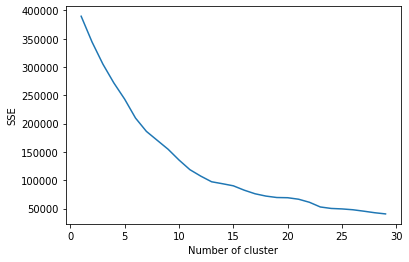

In [6]:
sse = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, max_iter=500).fit(X_train)
    X_train["cluster"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

So the best *K* is 10.

In [12]:
#X_train.drop(columns=['cluster'], axis=1, inplace=True)

best_k = 10

kmeans = KMeans(n_clusters=best_k, max_iter=1000).fit(X_train)
X_train["cluster"] = kmeans.labels_

In [13]:
X_train.reset_index(inplace=True)

In [17]:
X_train[(X_train['cluster'] == 3)].set_index(['ip', 'user_agent'])

,,requests_count,path_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),total_response_length,mean_response_length,total_response_time,mean_response_time,avg_path_count_norm,robots_txt_reqs,is_bot,is_pc,avg_time_diff,cluster
ip,user_agent,,,,,,,,,,,,,,,,
102.113.30.142,Go-http-client/1.1,-0.092392,0.000000,13.362090,-0.691768,-0.020735,-1.414275,-0.014118,-0.342754,-0.085811,-0.154421,0.000081,-0.041072,0,0,0.920933,3
102.57.85.148,MobileSafari/604.1 CFNetwork/1209 Darwin/20.2.0,-0.098698,0.894427,10.668303,-0.691768,-0.020735,3.788991,-0.012735,0.034033,-0.085828,-0.154527,0.068361,-0.041072,0,0,1.935220,3
102.86.228.109,MobileSafari/604.1 CFNetwork/1220.1 Darwin/20.3.0,-0.098698,0.447214,10.668303,-0.691768,-0.020735,3.788991,-0.012931,-0.019169,-0.085819,-0.154432,0.317986,-0.041072,0,0,1.935282,3
102.90.190.219,MobileSafari/604.1 CFNetwork/1240.0.4 Darwin/20.5.0,-0.098698,0.447214,10.668303,-0.691768,-0.020735,3.788991,-0.012931,-0.019169,-0.085820,-0.154448,0.317986,-0.041072,0,0,1.935280,3
113.111.41.156,MobileSafari/604.1 CFNetwork/1240.0.4 Darwin/20.5.0,-0.098698,0.447214,10.668303,-0.691768,-0.020735,3.788991,-0.012931,-0.019169,-0.085826,-0.154512,0.317986,-0.041072,0,0,1.935246,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92.232.118.19,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1) AppleWebKit/601.2.4 (KHTML, like Gecko) Version/9.0.1 Safari/601.2.4 facebookexternalhit/1.1 Facebot Twitterbot/1.0",-0.089240,0.462910,9.994856,-0.691768,-0.020735,2.488174,-0.012239,-0.022735,-0.085819,-0.154492,0.396274,-0.041072,1,1,0.631184,3
92.239.202.51,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1) AppleWebKit/601.2.4 (KHTML, like Gecko) Version/9.0.1 Safari/601.2.4 facebookexternalhit/1.1 Facebot Twitterbot/1.0",-0.076630,0.937437,6.627623,-0.691768,-0.020735,1.187358,-0.008397,0.306853,-0.085751,-0.154228,0.264277,-0.041072,1,1,-0.001110,3
92.239.24.24,MobileSafari/604.1 CFNetwork/1197 Darwin/20.0.0,-0.098698,0.447214,10.668303,-0.691768,-0.020735,3.788991,-0.012931,-0.019169,-0.085828,-0.154527,0.317986,-0.041072,0,0,1.935232,3


In [23]:
temp = X_train.reset_index()

temp

,index,ip,user_agent,requests_count,path_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),total_response_length,mean_response_length,total_response_time,mean_response_time,avg_path_count_norm,robots_txt_reqs,is_bot,is_pc,avg_time_diff,cluster
0,0,1.81.122.235,Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like M...,-0.092392,0.000000,-0.106843,-0.691768,-0.020735,-1.414275,-0.007792,0.888510,-0.085724,-0.153765,0.002439,-0.041072,0,0,0.920889,2
1,1,10.92.2.8,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,-0.026188,0.507875,-0.106843,-0.691768,-0.020735,0.072372,-0.002908,0.202744,-0.085566,-0.154088,0.725792,-0.041072,0,0,-0.656958,1
2,2,100.92.35.41,Mozilla/5.0 (Linux; Android 9; SM-A205F) Apple...,-0.076630,0.834847,-0.106843,-0.691768,-0.020735,-1.414275,-0.004082,0.796748,-0.085715,-0.154070,0.879623,-0.041072,0,0,-0.001192,2
3,3,102.0.232.185,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,-0.064019,0.516398,-0.106843,-0.691768,-0.020735,-1.414275,-0.014094,-0.340697,0.412804,1.482227,1.435493,-0.041072,0,1,-0.296272,2
4,4,102.0.232.220,Mozilla/5.0 (Linux; Android 11; SM-A505F) Appl...,-0.070324,0.267261,-0.106843,-0.691768,-0.020735,0.444034,-0.007501,0.301207,-0.085757,-0.154302,1.739906,-0.041072,0,0,-0.171579,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33446,33446,99.239.78.14,Mozilla/5.0 (MSIE 10.0; Windows NT 6.1; WOW64;...,-0.092392,0.377964,3.741423,-0.691768,-0.020735,0.072372,-0.011221,0.221202,-0.085744,-0.153912,0.340998,-0.041072,0,1,0.920906,2
33447,33447,99.239.78.14,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,-0.070324,0.267261,-0.106843,1.834395,-0.020735,0.444034,-0.013680,-0.300162,-0.085795,-0.154444,1.892610,-0.041072,0,1,-0.171387,0
33448,33448,99.239.78.14,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,-0.045104,0.394771,-0.106843,-0.691768,-0.020735,0.950846,-0.006177,0.149030,-0.085757,-0.154407,1.351409,-0.041072,0,1,-0.528086,1
33449,33449,99.239.78.14,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,-0.048256,0.358569,-0.106843,-0.691768,-0.020735,1.063470,-0.006347,0.161431,-0.085768,-0.154425,1.414657,-0.041072,0,1,-0.499072,1


In [12]:
#ip = X_train.iloc[-2].ip
#ua = X_train.iloc[-2].user_agent

ip = '102.29.29.19'
ua = 'Python-urllib/3.7' 

requests_df[(requests_df['user_agent'] == ua)].sort_values('time_stamp', ascending=True).head(20)

,ip,time,method,status_code,path,response_length,user_agent,response_time,path_count_normalized,path_length,time_stamp
120065,126.54.10.225,2021-05-12 07:03:17+04:30,Get,200,robots.txt,4825,Python-urllib/3.7,4.0,0.011353,1,1620786797


# Isolation Forest

In [55]:
X = X_train[X_train['cluster'] == 5].set_index(['ip', 'user_agent'])

to_model_cols = X.columns[:-1]
print(to_model_cols)

if_model = IsolationForest(bootstrap=False,
                     #bootstrap: randomly re-sample initial sample with replacement
                     contamination=float(.12),
                     #contamination: % of outliers (if known), no effect on score
                     max_features=1.0,
                     #max_features: # of randomly selected features at each node
                     max_samples='auto',
                     #max_samples: # of samples to draw from the initial samples 
                     #for each tree
                     n_estimators=200,
                     #n_estimators: # of trees in the forest
                     n_jobs=-1,
                     #n_jobs: # of cores used for parallelization, -1 means max available
                     random_state=42,
                     #random_state: sets the seed for reproducibility
                     verbose=0,
                     #verbose: control the verbosity of the output
                     warm_start=False)
                     #warm_start: reuse the solution from the previous call 
                     #and add more trees to the old ensemble
        
if_model.fit(X[to_model_cols])

y_pred = if_model.predict(X[to_model_cols])
y_score = if_model.decision_function(X[to_model_cols])
X['anomaly'] = y_pred

# result dataframe with columns : score and prediction
result_df = pd.DataFrame(if_model.decision_function(X[to_model_cols]), 
            columns=['score'])
result_df['prediction'] = y_pred

outliers = X.loc[X['anomaly'] == -1]
inliers = X.loc[X['anomaly'] == 1]

outlier_index = list(outliers.index)
inlier_index = list(inliers.index)

print(X['anomaly'].value_counts())
print("Note: -1 indicates anomaly")

Index(['requests_count', 'path_length_std', '4xx_percentage(%)',
       '3xx_percentage(%)', 'HEAD_count(%)', 'image_count(%)',
       'total_response_length', 'mean_response_length', 'total_response_time',
       'mean_response_time', 'avg_path_count_norm', 'robots_txt_reqs',
       'is_bot', 'is_pc', 'avg_time_diff'],
      dtype='object')
 1    7011
-1     957
Name: anomaly, dtype: int64
Note: -1 indicates anomaly


In [44]:
session_df.reset_index(inplace=True)

In [57]:

top_anomalies = session_df.loc[result_df[result_df['prediction'] == -1].sort_values(['score'], ascending=True).index]
top_non_anomalies = session_df.loc[result_df[result_df['prediction'] == 1].sort_values(['score'], ascending=False).index]

ip = top_anomalies.iloc[0].ip
ua = top_anomalies.iloc[0].user_agent

requests_df[(requests_df['ip'] == ip) & (requests_df['user_agent'] == ua)].sort_values('time_stamp', ascending=True).head(20)



,ip,time,method,status_code,path,response_length,user_agent,response_time,path_count_normalized,path_length,time_stamp
905386,153.126.65.49,2021-05-12 13:10:19+04:30,Get,200,pages/2098538398,51021,Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A72...,20.0,0.159106,2,1620808819
905456,153.126.65.49,2021-05-12 13:10:20+04:30,Get,304,fonts/sanjagh_icon_font_5.woff,0,Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A72...,16.0,2.326355,2,1620808820
905454,153.126.65.49,2021-05-12 13:10:20+04:30,Get,304,images/aparat_logo.png,0,Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A72...,8.0,2.090032,2,1620808820
905453,153.126.65.49,2021-05-12 13:10:20+04:30,Get,304,fonts/fontawesome_webfont.woff2?v=4.7.0,0,Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A72...,8.0,2.586109,2,1620808820
905452,153.126.65.49,2021-05-12 13:10:20+04:30,Get,304,fonts/IRANSansWeb_Light.woff2,0,Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A72...,12.0,2.742880,2,1620808820
905437,153.126.65.49,2021-05-12 13:10:20+04:30,Get,304,js/page.07cb314dc14eef820638.js,0,Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A72...,8.0,1.444591,2,1620808820
905436,153.126.65.49,2021-05-12 13:10:20+04:30,Get,304,js/lazyload.797291581158393f5011.js,0,Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A72...,8.0,2.683537,2,1620808820
905438,153.126.65.49,2021-05-12 13:10:20+04:30,Get,304,js/sentry.47b4061bac0b8ac89b9c.js,0,Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A72...,4.0,2.898040,2,1620808820
905432,153.126.65.49,2021-05-12 13:10:20+04:30,Get,304,images/default.jpg,0,Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A72...,4.0,1.171793,2,1620808820
905431,153.126.65.49,2021-05-12 13:10:20+04:30,Get,304,images/gadgets/join_pros3.jpg,0,Mozilla/5.0 (Linux; Android 11; SAMSUNG SM-A72...,4.0,1.475430,3,1620808820
